# Rotating Analyzer Ellipsometry

**Scott Prahl**

**April 2020**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pypolar.fresnel as fresnel
import pypolar.ellipsometry as ell

## Ellipsometer Layout

A basic ellipsometer configuration is shown below.  Typically the incident light is linearly polarized but the reflected light is, in general, elliptically polarized. 

<img src="http://omlc.org/~prahl/host/453/week5/ellipsometry.png" width="100%">

$$
E_{rs} = r_s e^{j\delta_s} E_{is} 
$$
and
$$
E_{rp} = r_p e^{j\delta_p}E_{ip} 
$$


The parameter $\Delta$ describes the change in phase from parallel polarization after reflection (because $E_p$ and $E_s$ are in phase before incidence).  The amplitude ratio (parallel vs perpendicular reflected light) is represented by $\tan\psi$.  

# Rotating Ellipsometer

An ellipsometer is usually used at a single angle of incidence with linear or circularly polarized light.  The reflected light passes through a rotating analyzer before hitting the detector. The reflected light is monitored over 360° with each rotation.  This produces a sinusoidal signal that looks like

$$
I(\phi) = I_\mathrm{DC} + I_C \cos 2\phi + I_S \sin 2\phi
$$

where $\phi$ is the angle that the analyzer makes with the plane of incidence.  To extract the index of refraction of a substrate three things must be done

1. fit the ellipsometer signal to obtain $I_\mathrm{DC}$, $I_S$, and $I_C$
2. calculate $\alpha =I_C/I_\mathrm{DC}$ and $\beta =I_S/I_\mathrm{DC}$
2. calculate $\rho =\tan\psi\cdot\exp(j\Delta)$ from $\alpha$ and $\beta$
3. calculate the index of refraction using $\rho$


## Fitting to a sinusoid

We want to fit the detected signal $I(\phi)$ to find average value $I_\mathrm{DC}$ as well as the two Fourier coefficients $I_S$ and $I_C$ 

$$
I(\phi) = I_\mathrm{DC} + I_C \cos 2\phi + I_S \sin 2\phi
$$


Our ellipsometer digitizes the signal every 5 degrees to produce an array of 72 elements, $I_i$.  The first challenge is to determine the coefficients $I_\mathrm{DC}$, $I_S$, and $I_C$ using these discrete data points

$$
I_i = I_\mathrm{DC}  + I_C \cos2\phi_i + I_S \sin2\phi_i
$$

where, $\phi_i=2\pi i/N$.


The DC offset $I_\mathrm{DC}$ is found by averaging over one analyzer rotation ($0\le\phi\le2\pi$)

$$
I_\mathrm{DC} = {1\over N}\sum_{i=0}^{N-1} I_i
$$

The Fourier coefficients are given by

$$ 
 I_S = {1\over \pi} \int_0^{2\pi} I(\phi)\sin(2\phi) \,{\rm d} \phi 
\qquad\mbox{and}\qquad
 I_C = {1\over \pi} \int_0^{2\pi} I(\phi)\cos(2\phi) \,{\rm d} \phi
$$

For the discrete case this becomes

$$ 
 I_S = {1\over \pi} \sum_{i=0}^{N-1} I_i\sin2\phi_i  \cdot \Delta\phi
\qquad\mbox{and}\qquad
 I_C = {1\over \pi} \sum_{i=0}^{N-1} I_i\cos2\phi_i \cdot \Delta\phi
$$

where $\Delta\phi=2\pi/N$.  

If we substitute for for $\Delta\phi$, then we recognize that $I_C$ and $I_S$ are just the weighted averages of $I_i$ over one drum rotation
$$
 I_S = {1\over N} \sum_{i=0}^{N-1} I_i\cdot 2\sin 2\phi_i
\qquad\mbox{and}\qquad
 I_C = {1\over N} \sum_{i=0}^{N-1} I_i\cdot 2\cos 2\phi_i
$$
where the quantities in brackets need only be calculated once at the beginning of the analysis.  Every rotation of the drum requires three averages to be calculated.

Below is a test with random noise added to a known sinsoidal signal.

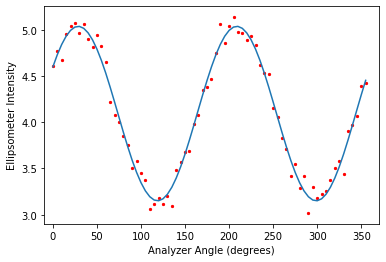

I_DC expected=4.100 obtained=4.093
I_S  expected=0.800 obtained=0.797
I_C  expected=0.500 obtained=0.505


In [2]:
degrees = np.linspace(0,360,num=72,endpoint=False)
phi = degrees*np.pi/180

# this is the signal we will try to recover
a=4.1
b=0.8
c=0.5
error=0.1
signal=ell.rotating_analyzer_signal(phi,a,b,c,error)

# finding the offset and coefficients of the sin() and cos() terms
# np.average sums the array and divides by the number of elements N
I_DC = np.average(signal)
I_S = 2*np.average(signal*np.sin(2*phi))
I_C = 2*np.average(signal*np.cos(2*phi))

plt.scatter(degrees,signal,s=5,color='red')
plt.plot(degrees,I_DC + I_S*np.sin(2*phi) + I_C*np.cos(2*phi))
plt.xlabel("Analyzer Angle (degrees)")
plt.ylabel("Ellipsometer Intensity")
plt.xlim(-10,370)
plt.show()

print("I_DC expected=%.3f obtained=%.3f" % (a,I_DC))
print("I_S  expected=%.3f obtained=%.3f" % (b,I_S))
print("I_C  expected=%.3f obtained=%.3f" % (c,I_C))

## Isotropic, Homogeneous Materials

Converting $\alpha$ and $\beta$ to surface properties requires a physical model for the surface.  The simplest model is that of an isotropic flat material with reflection determined by the Fresnel reflection properties.  

Tompkins 2005, page 282, writes
>The major problem with this approach is that it ignores the surface layer of the material. All materials have this surface overlayer, which may due to surface roughness, surface oxide, surface reconstruction, etc. Therefore, any realistic model of the sample is more complicated than a simple air/material, and [this analysis] is not valid for any model involving a surface overlayer. However, [it] is quite useful as a limiting case ...

The expression for the electric field at the detector can be found using Jones matrices.  The incident light passes through a linear polarizer at an angle $\theta_p$ relative to the plane of incidence.  The light is reflected off the surface and then passes through a linear analyzer at an angle $\phi$.  The electric field is

$$
E_D=
\left[\begin{array}{cc}
\cos^2\phi & \sin \phi\cos\phi\\
\sin\phi\cos\phi & \sin^2\phi\\
\end{array}\right]
\cdot
\left[\begin{array}{cc}
r_p(\theta_i) & 0\\
0 & r_s(\theta_i)\\
\end{array}\right]
\cdot
\left[\begin{array}{cc}
\cos^2\theta_p & \sin \theta_p\cos \theta_p\\
\sin \theta_p\cos \theta_p & \sin^2 \theta_p\\
\end{array}\right]
\cdot
\left[\begin{array}{c}
1\\
0\\
\end{array}\right]
$$

Therefore

$$
E_D=\left[\begin{array}{cc}
r_p(\theta_i)\cos^2\theta_p\cos^2\phi+r_s(\theta_i)\cos \theta_p\cos\phi\sin \theta_p \sin\phi\\
r_p(\theta_i)\cos^2 \theta_p\cos\phi\sin\phi+r_s(\theta_i)\cos P\sin \theta_p \sin^2\phi\\
\end{array}\right]
$$

and since the intensity is product of $E_D$ with its conjugate transpose $I=E_D\cdot E_D^T$ with a bit of algebra we find that

$$
I_\mathrm{measured} = \cos^2\theta_p \cdot\left|r_p(\theta_i)\cos\theta_p \cos\phi+r_s(\theta_i)\sin\theta_p \sin\phi\right|^2
$$

and with even more algebra this can be related back to the sinusoidal function

$$
I(\phi) = I_\mathrm{DC} + I_C \cos 2\phi + I_S \sin 2\phi
$$

which leads to

$$
\alpha = {I_C\over I_\mathrm{DC}} = {\tan^2\psi -\tan^2 \theta_p \over \tan^2\psi+\tan^2 \theta_p}
\qquad
\mbox{and}
\qquad
\beta = {I_S\over I_\mathrm{DC}} = {2\tan\psi \cos\Delta \tan \theta_p \over \tan^2\psi+\tan^2 \theta_p}
$$



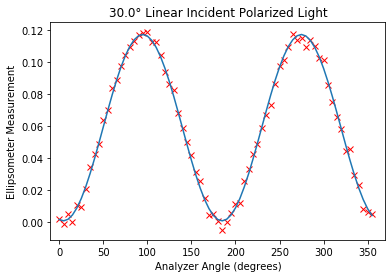

In [3]:
# create signal
m=3-0.2j                # sample index of refraction
P=30                    # incident polarization azimuth (degrees)
theta_p = np.radians(P) # incident polarization azimuth (radians)
th=70                   # angle of incidence (degrees)
theta = np.radians(th)  # angle of incidence (radians)

# Generate 72 intensities based on experimental conditions
# On reflected intensity for each angle of the rotating analyzer
phi_deg = np.linspace(0,360,num=72,endpoint=False)
phi = np.radians(phi_deg)
signal = ell.rotating_analyzer_signal_from_m(phi, m, theta, theta_p, noise=0.003)
average = signal.mean()

# analyze signal
rho = ell.rho_from_rotating_analyzer_data(phi, signal, theta_p)
fit = ell.rotating_analyzer_signal_from_rho(phi, rho, theta_p, average=average)

# display data and fit
plt.plot(degrees,signal,'xr')
plt.plot(degrees,fit)

plt.xlabel("Analyzer Angle (degrees)")
plt.ylabel("Ellipsometer Measurement")
plt.title("%.1f° Linear Incident Polarized Light" % np.degrees(theta_p))
plt.xlim(-10,370)
plt.show()

## Ellipsometry Parameters

If linearly polarized light is incident with an azimuthal angle $\theta_p$ 
(where $\theta_p=0^\circ$ is in the plane of incidence) then
the normalized intensity is 

$$
{I(\phi)\over I_\mathrm{DC}} = 1 + \alpha \cos 2\phi + \beta\sin 2\phi
$$

### No quarter wave plate in the incident beam ($0\le\theta_p\le90°$)



The parameters $\psi$ and $\Delta$ can now be calculated from $\alpha$ and $\beta$

$$
\tan\psi = \sqrt{1+\alpha\over 1-\alpha}\cdot |\tan \theta_p| 
\qquad
\mbox{and}
\qquad
\cos\Delta = {\beta\over\sqrt{1-\alpha^2}}\cdot{\tan \theta_p\over |\tan \theta_p|} 
$$

Or in terms of $I_\mathrm{DC}$, $I_S$, and $I_C$

$$
\tan\psi = \sqrt{I_\mathrm{DC}+I_C\over I_\mathrm{DC}-I_C}\cdot |\tan \theta_p|
\qquad
\mbox{and}
\qquad
\cos\Delta = {I_S\over\sqrt{I_\mathrm{DC}^2-I_C^2}}\cdot{\tan \theta_p\over |\tan \theta_p|}
$$

### Example

* generate a theoretical ellipsometer signal
* fit the signal to determine m



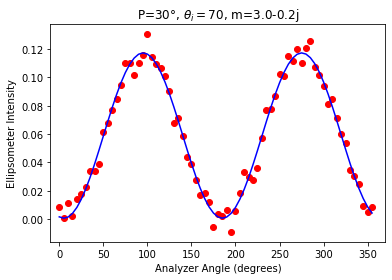

Fitted Delta=141.6°, tanpsi=0.067
Original  refractive index = 3.000-0.200j
Recovered refractive index = 3.006-0.226j


In [4]:
# Experimental Conditions
m=3-0.2j              # sample index of refraction
P=30                    # incident polarization azimuth (degrees)
theta_p = np.radians(P) # incident polarization azimuth (radians)
th=70                   # angle of incidence (degrees)
theta_i = np.radians(th)  # angle of incidence (radians)

# Generate 72 intensities based on experimental conditions
# On reflected intensity for each angle of the rotating analyzer
phi_deg = np.linspace(0,360,num=72,endpoint=False)
phi = np.radians(phi_deg)
signal = ell.rotating_analyzer_signal_from_m(phi, m, theta_i, theta_p, noise=0.005)

# Calculate Delta, tanpsi, and index from 72 intensities
rho = ell.rho_from_rotating_analyzer_data(phi, signal, theta_p)
m2 = ell.m_from_rho(rho, theta_i)

# use rho to calculate fitted values
average = signal.mean()
fit = ell.rotating_analyzer_signal_from_rho(phi,rho,theta_p,average=average)

# Show the results
plt.plot(phi_deg,signal,'or')
plt.plot(phi_deg,fit,color="blue")
plt.title(r"P=%d°, $\theta_i=$%d, m=%.1f-%.1fj" % (P,th,m.real,-m.imag))
plt.xlabel("Analyzer Angle (degrees)")
plt.ylabel("Ellipsometer Intensity")
plt.xlim(-10,370)
plt.show()

print("Fitted Delta=%.1f°, tanpsi=%.3f" % (np.degrees(np.angle(rho)),np.abs(rho)))
print("Original  refractive index = %.3f%+.3fj" % (m.real,m.imag))
print("Recovered refractive index = %.3f%+.3fj" % (m2.real,m2.imag))

### Sensitivity to random gaussian noise



In [5]:
def rotating_analyzer_signal_from_rho_old(phi, rho, P, QWP=False, average=1, noise=0):
    """
    Create normalized rotating ellipsometer signal for sample.

    Generate the expected reading at each analyzer angle in an ellipsometer
    with a sample characterized by a material with an ellipsometer parameter
         rho = tan(psi)exp(j*Delta)

    This is a classic
        source :: polarizer :: QWP :: sample :: analyzer :: detector
    arrangement.  The QWP is oriented at +45° if present.

    Note that the default returned array is normalized between 0 and 1.
    therefore the noise should be scaled accordingly.

    Args:
        phi:     array of analyzer angles from 0 to 2pi   [radians]
        rho:     ellipsometer parameter for surface       [complex]
        P:       angle of polarizer                       [radians]
        QWP:     True if QWP is present
        average: average value of signal over 2pi         [AU]
        noise:   std dev of normal noise distribution     [AU]
    Returns:
        Array of ellipsometer readings for each angle phi [-]
    """
    tanpsi = np.abs(rho)
    Delta = np.angle(rho)
    if QWP:
        Delta -= np.pi/2
    base = (tanpsi**2-np.tan(P)**2) * np.cos(2*phi)
    base += 2*tanpsi*np.cos(Delta)*np.tan(P)*np.sin(2*phi)
    base /= tanpsi**2+np.tan(P)**2
    base += 1
    noise = np.random.normal(0, noise, len(phi))
    return average*base+noise


m=3.000-0.200  expected
m=1.754+0.000  error=12.505%
m=0.699-0.944  error=6.253%
m=3.245-0.364  error=3.126%
m=5.667+0.000  error=1.563%
m=2.238-1.207  error=0.782%
m=2.489-1.054  error=0.391%
m=4.133+0.000  error=0.195%
m=3.362+0.000  error=0.098%
m=2.969-0.384  error=0.049%
m=3.002-0.173  error=0.024%
m=3.008-0.130  error=0.012%
m=2.995-0.230  error=0.006%
m=2.996-0.222  error=0.003%
m=3.000-0.196  error=0.002%
m=3.000-0.201  error=0.001%
m=3.000-0.197  error=0.000%


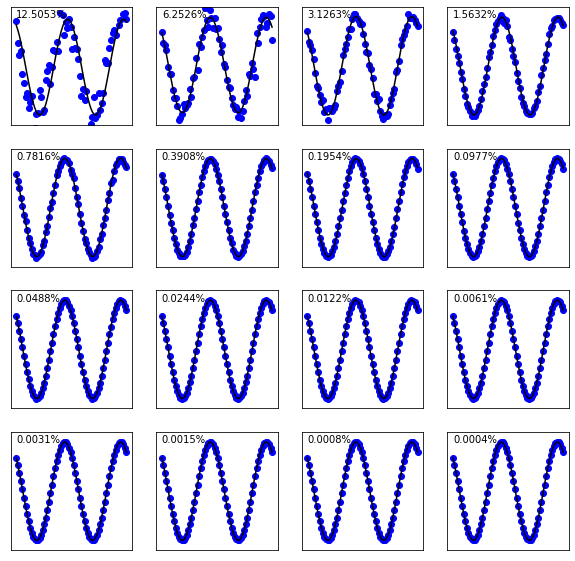

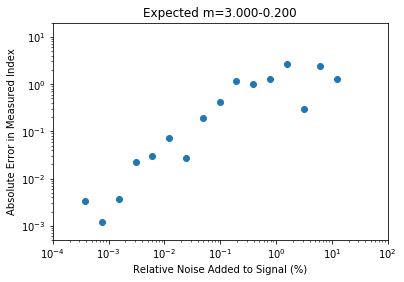

In [6]:
# Experimental Conditions
m=3.0-0.2j                # sample index of refraction
P=20                    # incident linear polarization angle (degrees)
theta_p = np.radians(P) # incident linear polarization angle (radians)
th=30                   # angle of incidence (degrees)
theta_i = np.radians(th)# angle of incidence (radians)

# Generate 72 intensities based on experimental conditions
phi = np.radians(np.linspace(0,360,num=72,endpoint=False))

# error free signal needed to scale the plots
signal = ell.rotating_analyzer_signal_from_m(phi, m, theta_i, theta_p)
scale = signal.mean()
ymax = signal.max()

N=16
dev = np.zeros(N)
err = np.zeros(N)
print("m=%.3f%+.3f  expected" % (m.real,m.imag))

# create fit plots for each error
plt.subplots(4,4,figsize=(10,10))
for i in range(N):
    error = scale*2**(-i-2)
    signal = ell.rotating_analyzer_signal_from_m(phi, m, theta_i, theta_p, noise=error)
    rho = ell.rho_from_rotating_analyzer_data(phi, signal, theta_p)
    fit = ell.rotating_analyzer_signal_from_rho(phi, rho, theta_p, average=signal.mean(), QWP=False)
    m2 = ell.m_from_rho(rho, theta_i)
    dev[i]=abs(m2-m)
    rel_error = 100*error/ymax
    err[i]=rel_error
    plt.subplot(4,4,i+1)
    plt.plot(np.degrees(phi), signal, 'ob')
    plt.plot(np.degrees(phi), fit, 'k')
    plt.ylim(-0.1*ymax,1.1*ymax)
    plt.text(0,0.99*ymax,'%.4f%%'%rel_error)
    plt.yticks([])
    plt.xticks([])
    
    print("m=%.3f%+.3f  error=%.3f%%" % (m2.real,m2.imag,rel_error))

plt.show()
plt.scatter(err,dev)
plt.xlim(1e-4,100)
plt.ylim(5e-4,20)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Relative Noise Added to Signal (%)')
plt.ylabel('Absolute Error in Measured Index')
plt.title("Expected m=%.3f%+.3f" % (m.real,m.imag))
plt.show()

## Real data

Here are some measurements on a silicon wafer at 632.8nm.  The incidence angle is 50°.  Two experiments were done.

No QWP, $\theta_p$ = 45°

QWP at 45°, $\theta_p$ = 0°

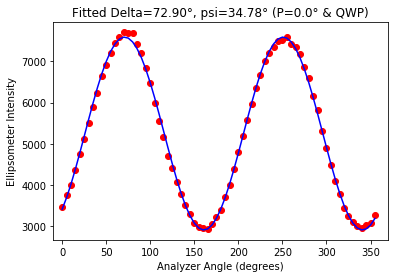

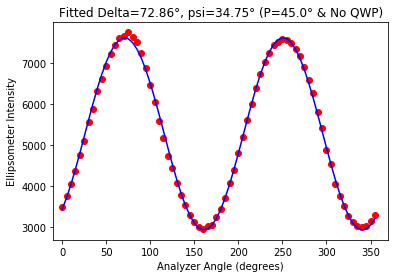

QWP    m=0.803-1.596j
No QWP m=0.805-1.595j


In [9]:
# Experimental Conditions
th=70                   # angle of incidence (degrees)
theta_i = np.radians(th)  # angle of incidence (radians)

# Generate 72 intensities based on experimental conditions
# On reflected intensity for each angle of the rotating analyzer
phi_deg = np.linspace(0,360,num=72,endpoint=False)
phi = np.radians(phi_deg)

theta_p=0
signal = np.array([3477,3768,4009,4371,4744,5126,5512,5891,6243,6635,6908,7209,7443,7582,7705,7684,7675,7415,7209,6845,6465,5996,5562,5166,4718,4420,4086,3782,3524,3292,3076,2993,2956,2948,3067,3230,3408,3711,4000,4389,4793,5193,5585,5973,6364,6667,7010,7206,7352,7492,7505,7588,7432,7338,7169,6855,6604,6162,5813,5315,4907,4501,4091,3784,3457,3246,3097,3012,2960,3046,3092,3268])
rho = ell.rho_from_rotating_analyzer_data(phi, signal, theta_p, QWP=True)

# Show the fit
fit = ell.rotating_analyzer_signal_from_rho(phi,rho,theta_p,average=signal.mean(),QWP=True)
plt.plot(phi_deg,signal,'or')
plt.plot(phi_deg,fit,color="blue")
psi = np.degrees(np.arctan(np.abs(rho)))
plt.title("Fitted Delta=%.2f°, psi=%.2f° (P=%.1f° & QWP)" % (np.degrees(np.angle(rho)), psi, np.degrees(theta_p)))
plt.xlabel("Analyzer Angle (degrees)")
plt.ylabel("Ellipsometer Intensity")
plt.xlim(-10,370)
plt.show()

m_qwp = ell.m_from_rho(rho, theta_i)

theta_p = np.pi/4
signal = np.array([3474,3752,4056,4357,4760,5094,5559,5890,6317,6612,6923,7223,7454,7607,7671,7757,7644,7528,7254,6883,6469,6051,5591,5178,4734,4445,4076,3774,3524,3283,3121,2997,2941,3008,3037,3238,3433,3712,4068,4391,4813,5205,5617,5992,6405,6734,7021,7253,7449,7509,7587,7569,7495,7344,7184,6909,6584,6264,5806,5405,4884,4525,4052,3748,3509,3265,3113,3007,2998,3020,3129,3285])
rho = ell.rho_from_rotating_analyzer_data(phi, signal, theta_p, QWP=False)

fit = ell.rotating_analyzer_signal_from_rho(phi, rho, theta_p, average=signal.mean())
plt.plot(phi_deg,signal,'or')
plt.plot(phi_deg,fit,color="blue")
psi = np.degrees(np.arctan(np.abs(rho)))
plt.title("Fitted Delta=%.2f°, psi=%.2f° (P=%.1f° & No QWP)" % (np.degrees(np.angle(rho)), psi, np.degrees(theta_p)))
plt.xlabel("Analyzer Angle (degrees)")
plt.ylabel("Ellipsometer Intensity")
plt.xlim(-10,370)
plt.show()

m_no_qwp = ell.m_from_rho(rho, theta_i)

print("QWP    m=%.3f%+.3fj" % (m_qwp.real,m_qwp.imag))
print("No QWP m=%.3f%+.3fj" % (m_no_qwp.real,m_no_qwp.imag))



## Not all measurements give equally good results

In [8]:
# Experimental Conditions
phi = np.radians(np.linspace(0,360,num=72,endpoint=False))
tanpsi = 0.5

print("   P     Delta  tanpsi     Delta  tanpsi  Delta tanpsi")
for P in [1, 45, 89, 91, 178, -10, -89]:
    for Del in [10, 67, 120, 178]:

        Delta   = np.radians(Del)
        theta_p = np.radians(P)
        rho0 = tanpsi*np.exp(1j*Delta)
        
        print("%6.1f° %6.1f° %6.3f:   " % (P,Del,tanpsi), end='')
#        print(" [%.2f° %.2f] " % (np.degrees(np.angle(rho0)),rho.imag),end='')

        signal = ell.rotating_analyzer_signal_from_rho(phi, rho0, theta_p, noise=0.0002)

        rho = ell.rho_from_rotating_analyzer_data(phi, signal, theta_p)
        print("%8.3f° %6.3f" % (np.degrees(np.angle(rho)),np.abs(rho)))


   P     Delta  tanpsi     Delta  tanpsi  Delta tanpsi
   1.0°   10.0°  0.500:      8.533°  0.502
   1.0°   67.0°  0.500:     67.167°  0.497
   1.0°  120.0°  0.500:    119.899°  0.497
   1.0°  178.0°  0.500:    170.966°  0.494
  45.0°   10.0°  0.500:      9.977°  0.500
  45.0°   67.0°  0.500:     67.000°  0.500
  45.0°  120.0°  0.500:    119.999°  0.500
  45.0°  178.0°  0.500:    177.950°  0.500
  89.0°   10.0°  0.500:     35.376°  0.605
  89.0°   67.0°  0.500:     65.483°  0.470
  89.0°  120.0°  0.500:    118.187°  0.533
  89.0°  178.0°  0.500:   -180.000°  0.618
  91.0°   10.0°  0.500:     -0.000°  0.753
  91.0°   67.0°  0.500:     66.120°  0.482
  91.0°  120.0°  0.500:    123.456°  0.455
  91.0°  178.0°  0.500:    156.810°  0.542
 178.0°   10.0°  0.500:     10.330°  0.499
 178.0°   67.0°  0.500:     67.109°  0.498
 178.0°  120.0°  0.500:    120.061°  0.501
 178.0°  178.0°  0.500:    174.914°  0.498
 -10.0°   10.0°  0.500:     10.021°  0.500
 -10.0°   67.0°  0.500:     67.010°  0.500